In [1]:
%load_ext autoreload

%autoreload 1

In [2]:
import glob
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns

from pprint import pprint

import re
from scipy.signal import correlate2d

import scipy

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import SNOM_Import
import hdf5storage

import scipy.io as sio


In [3]:
sys.path.append('/mnt/c/Users/conor/Git_Projects/PHD')

In [4]:
files = dict()

for i, file_path in tqdm(enumerate(glob.glob("/mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant/*HEADR*")[:])):

    file_name = file_path.split('/')[-1].split('HEADR')[0]
    files[file_name] = SNOM_Import.SNOM_File(file_path[:-14])

snom_files = pd.DataFrame({name: vars(file) for name, file in files.items()}).T


In [5]:
#kurtosis = pd.concat(pd.read_excel("/mnt/c/Users/conor/Git_Projects/PHD/Skewness.xlsx", sheet_name=None))

In [6]:
metadata = pd.read_excel('Insulin_Data_Summary_2.xlsx')
#metadata = metadata.drop_duplicates(subset='Scan Number')
#metadata.to_excel('metadata_nd.xlsx')

In [7]:
snom_files.index = [int(i[:4]) for i in snom_files.index]

In [8]:
df = snom_files.loc[:,['FSNOM','BSNOM']].reset_index().merge(metadata.reset_index(), left_on='index', right_on='index')

for batch_n, df_ in df.groupby('Batch'):

    fig, axes = plt.subplots(ncols=2, nrows=2)
    [ax.axis('off') for ax in axes.flatten()]

    for (index, row), ax in zip(df_.T.iteritems(), axes.flatten()):

        sensitivity = int(row.sensitivity.replace(' ','')[0])

        try:
            #bkg = bkgs[row.background_scan][row.wavenumber]
            ims=ax.imshow(row.FSNOM*sensitivity)
            ax.set_title(f'{index}\n'+ '\n'.join(row[['wavenumber','scan_size']]))
            fig.colorbar(ims, ax=ax)

        except:
            pass

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Plots_15_10_2020/{batch_n}.png', bbox_inches='tight')
        



In [9]:
for i, row in df.query("background_scan=='none' & Accept in ['y','Y']").iterrows():

    if row.FSNOM.min() < 0:
        plt.title(row.index)
        plt.imshow(row.FSNOM)

In [10]:
df.columns

Index(['index', 'FSNOM', 'BSNOM', 'level_0', 'Accept', 'Batch', 'fileName',
       'name', 'start_time', 'end_time', 'pre_scan', 'snom_mode', 'wavelength',
       'fel_power', 'scan_size', 'num_points', 'step_size', 'x-start',
       'y-start', 'sensitivity', 'scan_rate', 'fibre', 'afm_gain', 'amplitude',
       'frequency', 'vres', 'vref', 'wavenumber', 'pulse_rate', 'pulse_width',
       'time_constant', 'sample', 'background_scan', 'area', 'operator',
       'Scan Number', 'Wavenumber (cm-1)', 'Skewness', 'Kurtosis',
       'Kurtosis-3'],
      dtype='object')

In [11]:
df.loc[:,['index','Batch','Accept','sample']].query("sample=='C6 on Au with HI pH 2'")

index  Batch Accept                 sample
33    2290     45      n  C6 on Au with HI pH 2
34    2292     45      n  C6 on Au with HI pH 2
35    2293     45      n  C6 on Au with HI pH 2
36    2294     46      n  C6 on Au with HI pH 2
37    2295     46      n  C6 on Au with HI pH 2
38    2296     46      n  C6 on Au with HI pH 2
39    2297     47      n  C6 on Au with HI pH 2
40    2298     47      n  C6 on Au with HI pH 2
41    2299     47      n  C6 on Au with HI pH 2
45    2303     42      n  C6 on Au with HI pH 2
46    2304     42      n  C6 on Au with HI pH 2
47    2305     42      n  C6 on Au with HI pH 2
60    2322     53      n  C6 on Au with HI pH 2
61    2323     53      Y  C6 on Au with HI pH 2
62    2325     53      Y  C6 on Au with HI pH 2
63    2326     54      Y  C6 on Au with HI pH 2
64    2327     54      Y  C6 on Au with HI pH 2
65    2328     54      Y  C6 on Au with HI pH 2
66    2329     54      Y  C6 on Au with HI pH 2
112   2705     16      y  C6 on Au with HI pH 2
113   2706     16      y  C6 on Au with HI pH 2
114   2707     16      y  C6 on Au with HI pH 2
115   2708     17      y  C6 on Au with HI pH 2
116   2709     17      y  C6 on Au with HI pH 2
117   2710     17      y  C6 on Au with HI pH 2
118   2711     18      y  C6 on Au with HI pH 2
119   2712     18      y  C6 on Au with HI pH 2
120   2713     18      y  C6 on Au with HI pH 2
148   2750     29      y  C6 on Au with HI pH 2
149   2751     29      y  C6 on Au with HI pH 2
150   2752     29      y  C6 on Au with HI pH 2

In [12]:
df.loc[:,['index','Batch','Accept','sample']]['sample'].value_counts().index#.query("sample=='C6 on A with HI ph 2'")

Index(['C6 on Au with HI pH 2', 'C6/Au', 'C18 on Au with HI pH 2',
       'C18 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'Au', 'C18/Au'],
      dtype='object')

1626 Au
1651 Au
1689 Au
1626 C18/Au
1651 C18/Au
1689 C18/Au
1626 C6/Au
1651 C6/Au
1689 C6/Au


Text(0.5, 0, 'Pixel Intensity')

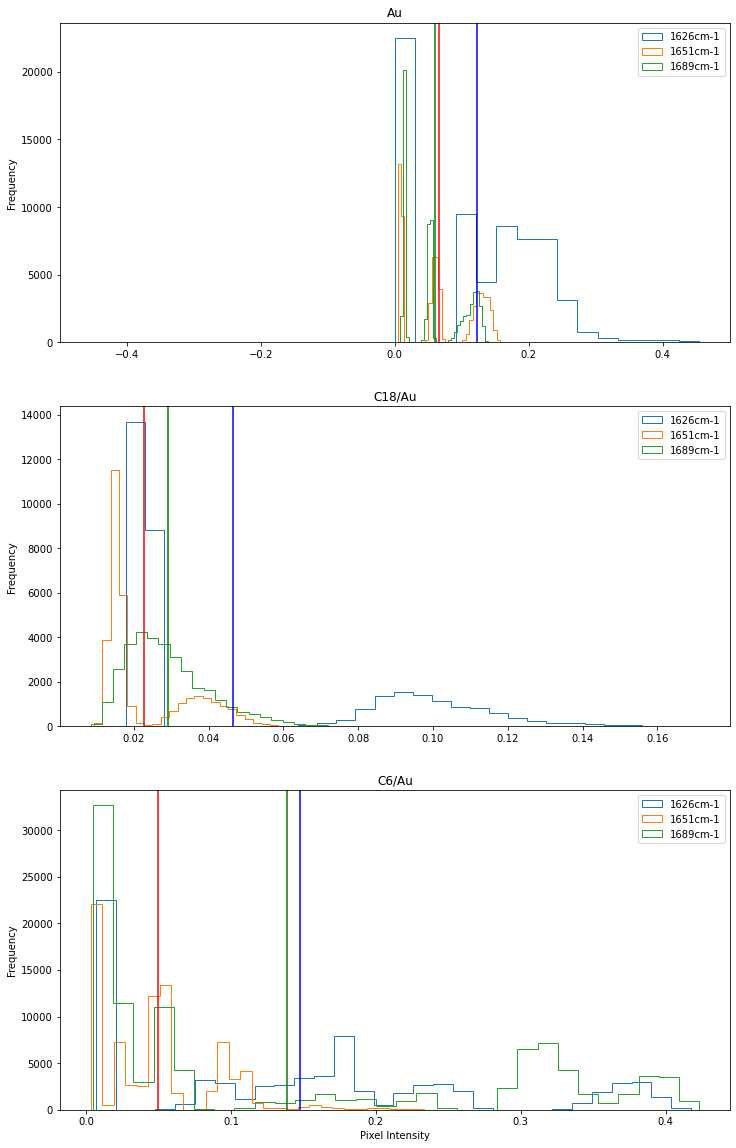

In [13]:
fig, axes = plt.subplots(nrows=3, figsize=(12,20), sharex=False)

# Dictionary containing the expectation value for each 
# total background and each wavelength
bkgs={}

df['wavenumber']=df.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), df.query("background_scan=='none' & Accept in ['y','Y']").groupby('sample')):

    wns={}
    for c, (wn, df_wn) in zip(['b','r','g'], df_.groupby('wavenumber')):
        
        wn=wn[:4]
        print(wn.replace(' ',''), name)

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        pulse_rate = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.pulse_rate]
        pulse_width = [int(re.search("(-?[0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        ims = np.concatenate([im.flatten()*sen/(pr*pw) for im, sen, pr, pw in zip(df_wn.FSNOM, sens, pulse_rate, pulse_width)])


        hist, bins = np.histogram(ims, bins=30)

        #print(hist.min(), bins.min())

        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2

        # Calculate expectation value of distribution
        exp = np.sum(center*(hist/hist.sum()))
        
        # Plot histograms and expectation value
        ax.axvline(exp, c=c)
        ax.hist(ims, bins=30, label=f'{wn.replace(" ","")}cm-1', histtype='step')

        wns[wn.replace(" ","")] = exp

    bkgs[name]=wns

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')

Generate Image files for Caroline

In [14]:
test_images={}

for file_ in tqdm(glob.glob('/mnt/c/Users/conor/Google Drive/PhD/SNOM_Creep_Corrected/*.mat')):

    file_dict = hdf5storage.loadmat(file_)

    for file_name, _file in file_dict.items():

        #try:
        snom_file=files[file_name[4:]+'-0-']
        
        sens = int(re.search("([0-9]+)", snom_file.sensitivity).groups()[0])

        try:
            bkg_scan=bkgs[df.loc[snom_file.name+'-','background_scan']][snom_file.wavenumber.replace(' ','')]
        except:
            continue

        FSNOM = (_file[0][0][0][0]*sens)#/bkg_scan
        BSNOM = (_file[0][0][0][1]*sens)#/bkg_scan
        FZERO = _file[0][0][0][2]
        BZERO = _file[0][0][0][3]
        FTOPO = _file[0][0][0][4]
        BTOPO = _file[0][0][0][5]

        FSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][0])
        BSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][1])
        FTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][4])
        BTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][5])

        data_files={
            'Name': file_name[4:]+'-0-',
            'FSNOM': FSNOM,
            'BSNOM': BSNOM,
            'FZERO': FZERO,
            'BZERO': BZERO,
            'FTOPO': FTOPO,
            'BTOPO': BTOPO,
            'FSNOM_Tilt_Corrected': FSNOM_Tilt_Corrected,
            'BSNOM_Tilt_Corrected': BSNOM_Tilt_Corrected,
            'FTOPO_Tilt_Corrected': FTOPO_Tilt_Corrected,
            'BTOPO_Tilt_Corrected': BTOPO_Tilt_Corrected,
        }

        test_images[file_name[4:]+'-0-'] = data_files

        file_path = os.path.join(os.getcwd(), 'tilt_corrected_files', 'CS')
        file_name = snom_file.name+'.mat'
        
        try: os.mkdir(file_path)
        except: pass

        sio.savemat(os.path.join(file_path, file_name), mdict=data_files)


for n, row in df.loc[['2750-0-','2751-0-','2752-0-'], ['wavenumber', 'FSNOM', 'BSNOM', 'FTOPO']].iterrows():
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    im = row.FSNOM

    fig.suptitle(n)
    ax1.imshow(im)
    ax2.imshow(SNOM_Import.plane_correct(im))

fig, ax = plt.subplots()

for n, row in df.loc[['2714-0-','2715-0-','2716-0-'], ['wavenumber', 'FSNOM']].iterrows():

    ax.hist(row.FSNOM.flatten(), label=f'{n} - {row.wavenumber}', histtype='step', bins=30)

plt.legend()

Text(0.5, 0, 'Pixel Intensity')

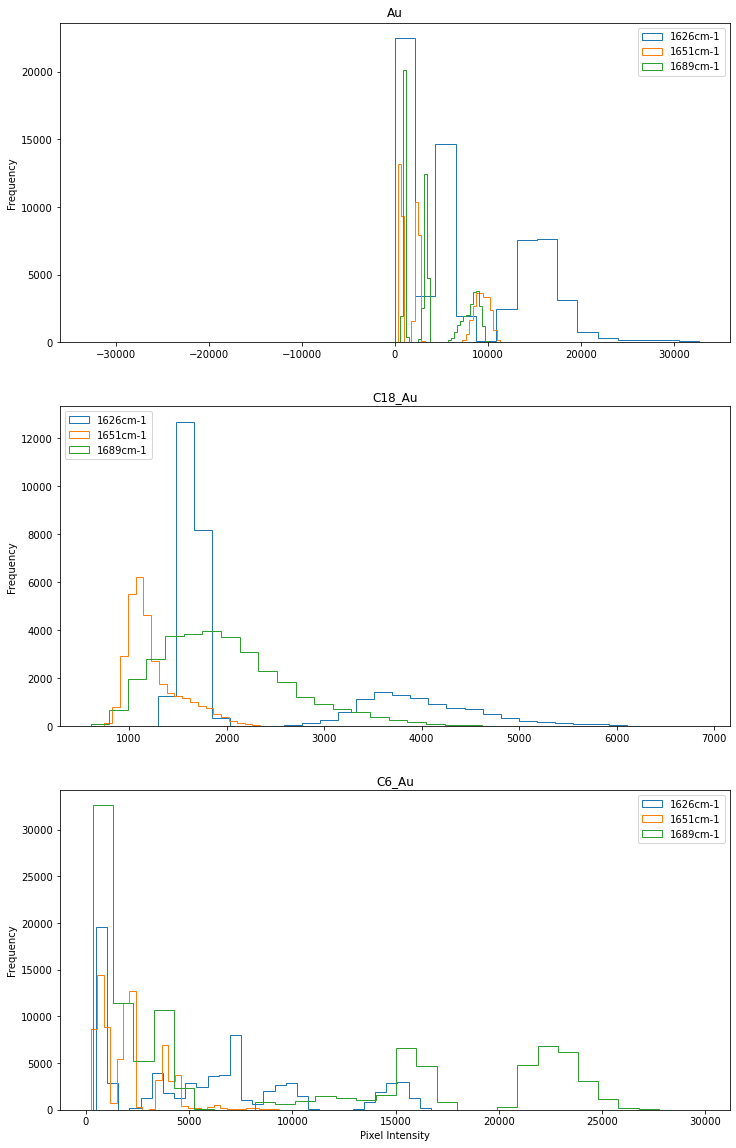

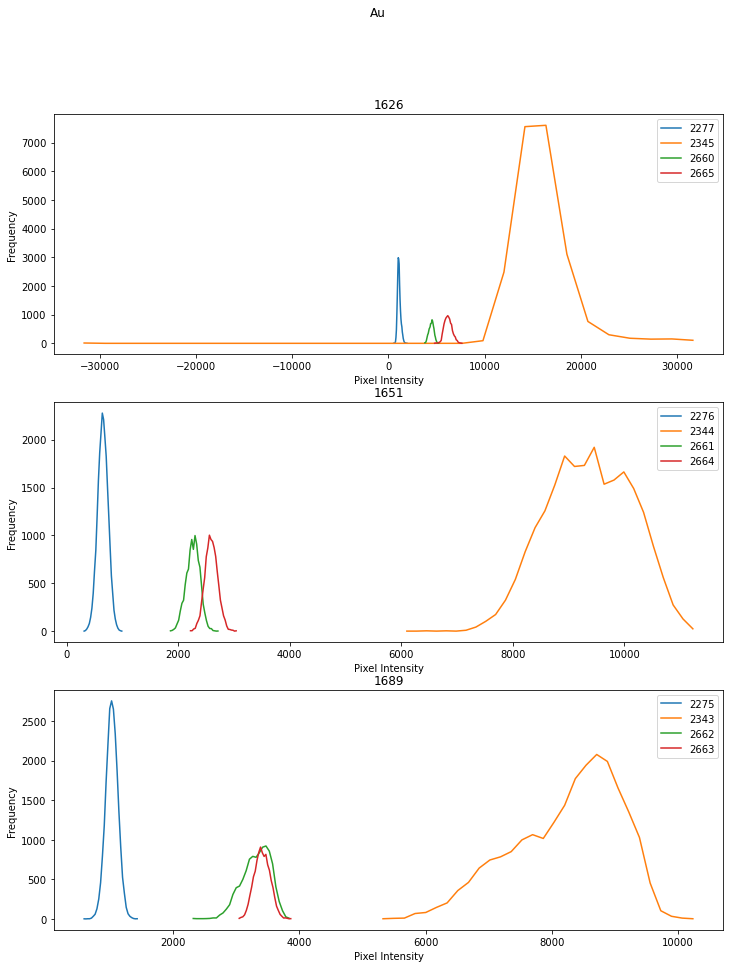

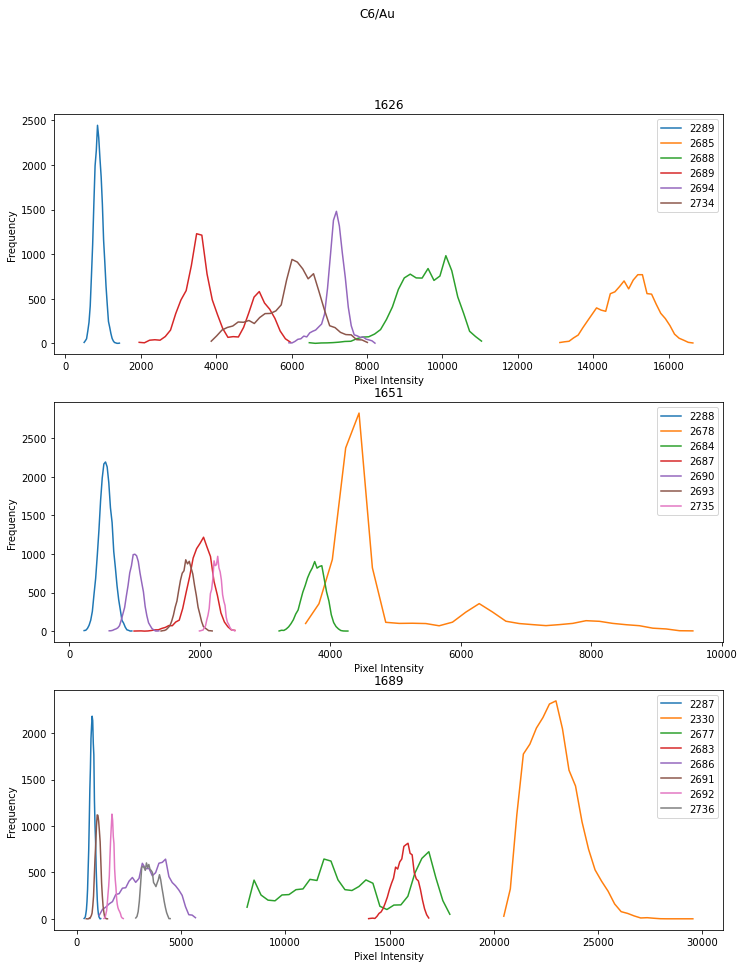

In [15]:
fig, axes = plt.subplots(nrows=3, figsize=(12,20), sharex=False)

dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=False)
    fig2.suptitle(f'{name}')


    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]

        total=[]

        #bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []
            fbsnom.append(np.concatenate(row.FSNOM))
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            text_x = (fbsnom.mean()*sensitivity)#/bkg
            #ax.text(text_x-(0.05*text_x), i*20, f"{row['Scan Number']}")

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity))#/bkg)

        total = np.concatenate(total)

        ax2.set_title(wn)

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()

        name=name.replace('/','_')

        fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten(), bins=len(hist), label=f'{wn}cm-1', histtype='step')

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')
#fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

Text(0.5, 0, 'Pixel Intensity')

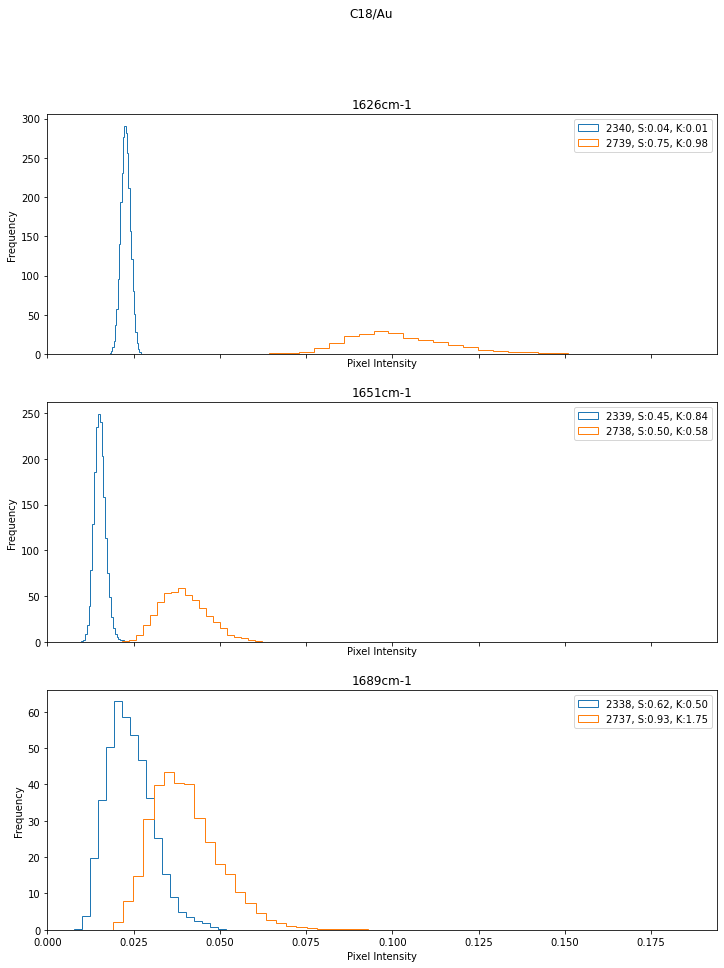

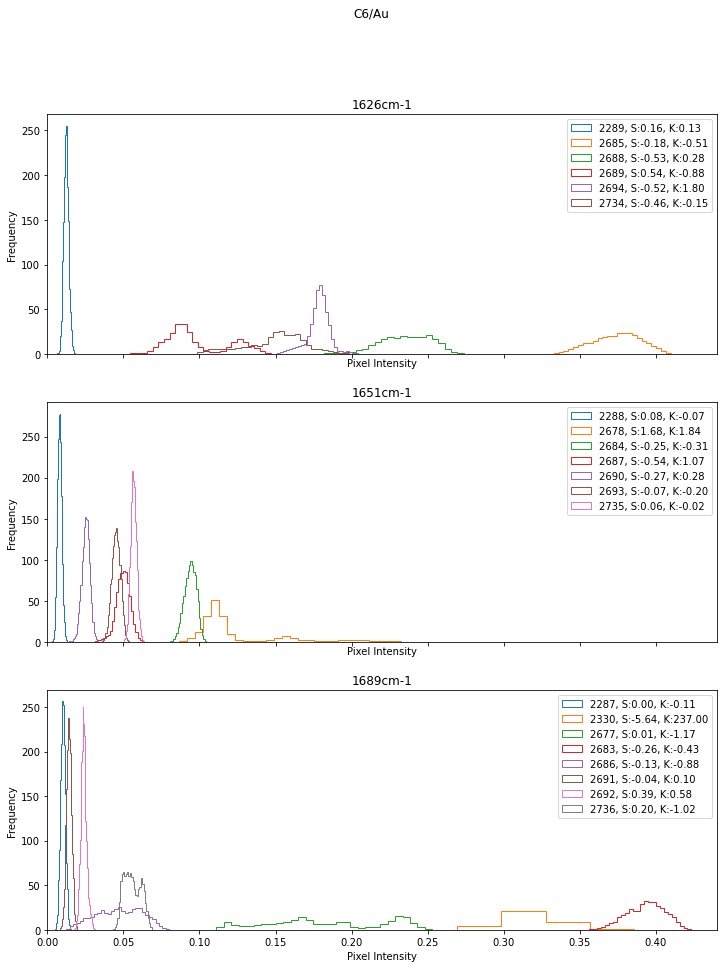

In [16]:
fig, axes = plt.subplots(nrows=4, figsize=(12,20), sharex=True)

dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=True)
    fig2.suptitle(f'{name}')

    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        #sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        #pw = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        total=[]

        #bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []

            for im in [row.FSNOM, row.BSNOM]:
                try:
                    fbsnom.append(np.concatenate(im))
                except:
                    pass
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
            pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
            pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            sk = scipy.stats.skew((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))
            ku = scipy.stats.kurtosis((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))


            ax2.hist((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate)
            , histtype='step'
            , label=f"{row['Scan Number']}, S:{sk:.2f}, K:{ku:.2f}"
            , bins=30
            , density=True)

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            #ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity)/(pulse_width*pulse_rate))

        total = np.concatenate(total)

        ax2.set_title(f'{wn}cm-1')

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()
        ax2.set_xlim(left=0)

        #fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten()
        , bins=30
        , label=f'{wn}cm-1'
        , histtype='step'
        , density=True)

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_xlim(left=0)

ax.set_xlabel('Pixel Intensity')
#fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

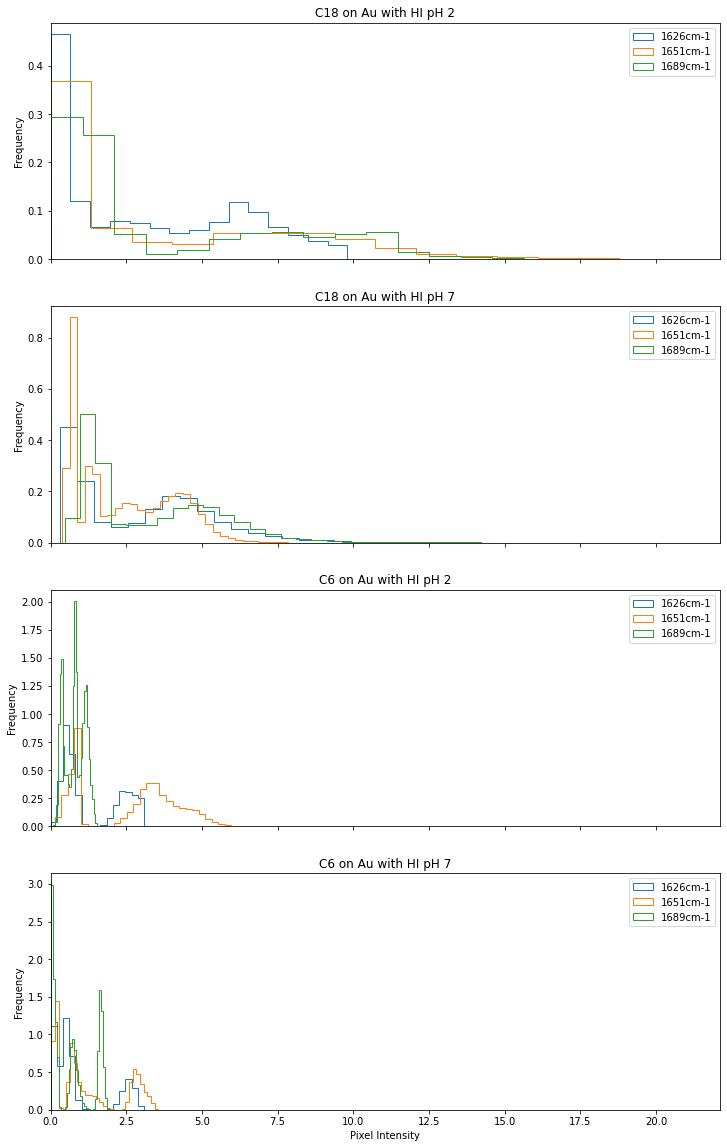

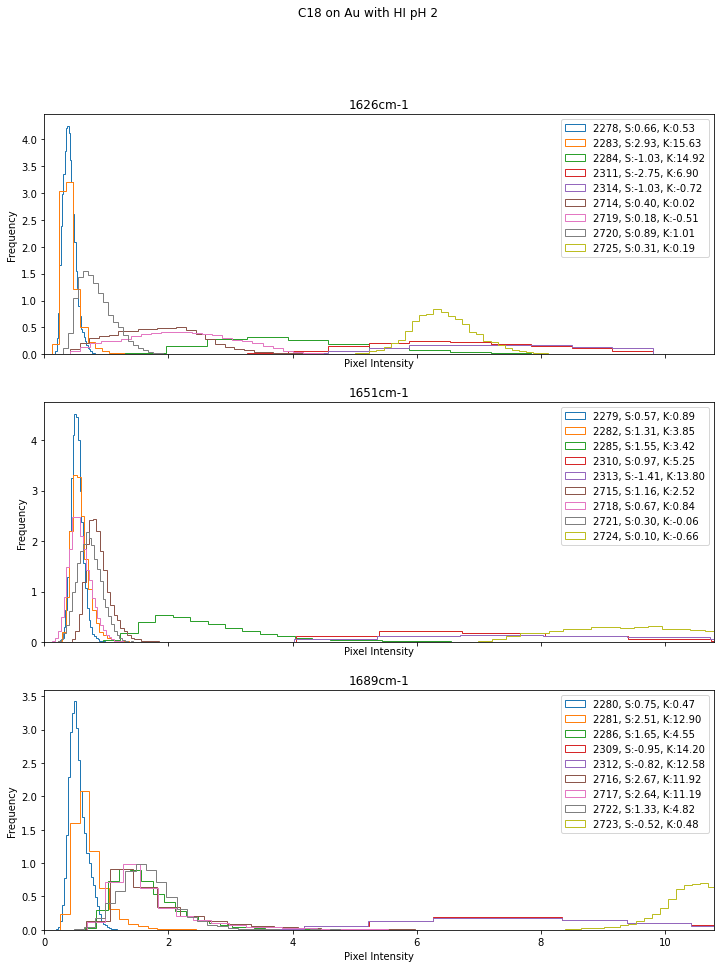

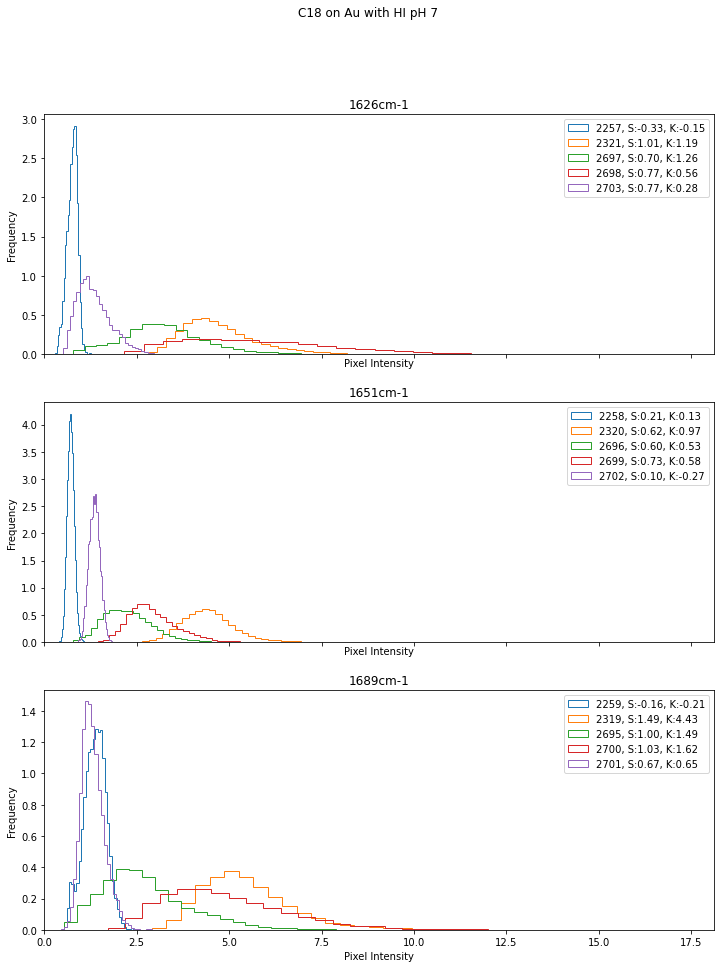

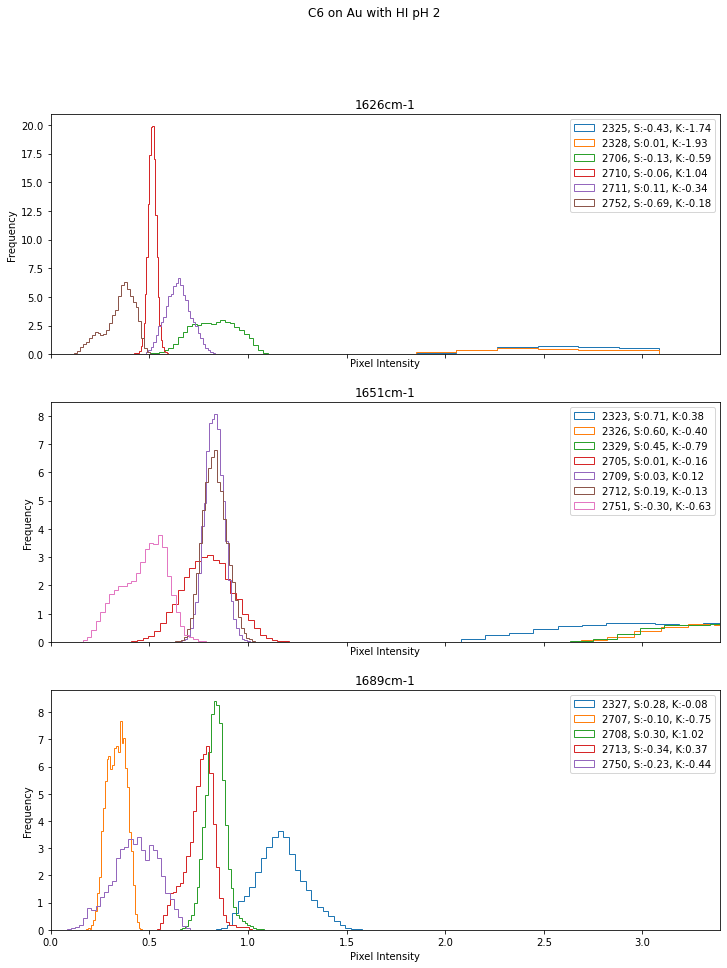

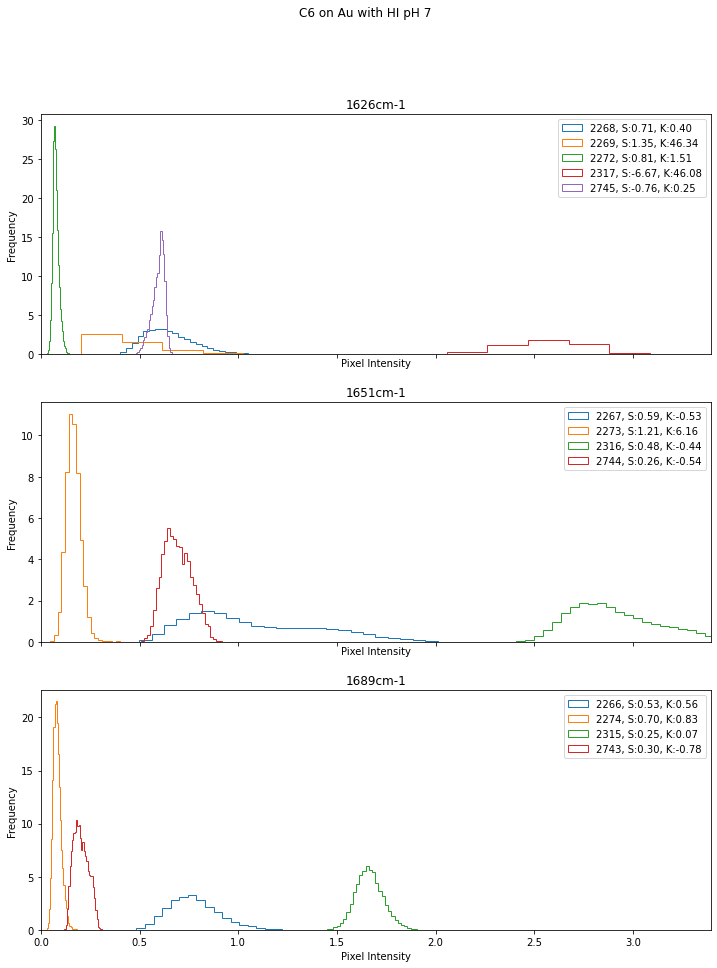

In [17]:
fig, axes = plt.subplots(nrows=4, figsize=(12,20), sharex=True)

dataset = df.query("background_scan!='none' & Accept in ['y','Y']")
dataset['wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ',''), axis=1)

for ax, (name, df_) in zip(axes.flatten(), dataset.groupby('sample')):

    wns={}

    fig2, axes2 = plt.subplots(nrows=3, figsize=(12,15), sharex=True)
    fig2.suptitle(f'{name}')

    for c, ax2, (wn, df_wn) in zip(['blue','orange','green','r'], axes2.flatten(), df_.groupby('wavenumber')):

        wn=wn[:4]

        # Extract the sensitivity of the lock in for each image.
        #sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]
        #pw = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.pulse_width]

        total=[]

        bkg = bkgs[df_wn.background_scan.tolist()[0]][wn]
        
        # For each image make the histogram
        for i, (idx, row) in enumerate(df_wn.iterrows()):
            
            fbsnom = []

            for im in [row.FSNOM, row.BSNOM]:
                try:
                    fbsnom.append(np.concatenate(im))
                except:
                    pass
            
            sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
            pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
            pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

            fbsnom = np.concatenate(fbsnom)

            sk = scipy.stats.skew((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))
            ku = scipy.stats.kurtosis((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))


            ax2.hist((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate)
            , histtype='step'
            , label=f"{row['Scan Number']}, S:{sk:.2f}, K:{ku:.2f}"
            , bins=30
            , density=True)

            hist, bins = np.histogram((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate), bins=30)

            width = 0.7* (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2 

            #ax.plot(center,hist,color=c,label=f"{row['Scan Number']}",ls=ls)
            #ax2.plot(center,hist, label=f"{row['Scan Number']}")

            total.append((fbsnom.flatten()*sensitivity)/(bkg*pulse_width*pulse_rate))

        total = np.concatenate(total)

        ax2.set_title(f'{wn}cm-1')

        ax2.set_ylabel('Frequency')
        ax2.set_xlabel('Pixel Intensity')
        ax2.legend()
        ax2.set_xlim(left=0)

        fig2.savefig(f'./Work_For_Caroline/20_11/{name}.pdf', bbox_inches='tight')
        ax.hist(total.flatten()
        , bins=30
        , label=f'{wn}cm-1'
        , histtype='step'
        , density=True)

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_xlim(left=0)

ax.set_xlabel('Pixel Intensity')
fig.savefig('/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/20_11/Total.pdf', bbox_inches='tight')

# Batched plots

In [18]:
row=dataset.iloc[0]

In [19]:
sensitivity = int(re.search("([0-9]+)", row.sensitivity).groups()[0])
pulse_width = int(re.search("([0-9]+)", row.pulse_width).groups()[0])
pulse_rate = int(re.search("([0-9]+)", row.pulse_rate).groups()[0])

In [20]:
dataset = df.query("background_scan!='none' & Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.Background*row.pulse_rate*row.pulse_width)), axis=1)

#

dataset = df.query("background_scan!='none' & Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.Background*row.pulse_rate*row.pulse_width)), axis=1)

dataset['Transmittance'] = np.abs(dataset.apply(lambda row: row.Transmittance/(row.Transmittance.max()),axis=1))


dataset = dataset.explode('Transmittance')
dataset = dataset.astype({'Transmittance': 'float32'})
dataset['Absorbance'] = -np.log10(dataset['Transmittance'])
#dataset['Absorbance'] = dataset['Absorbance'].replace([np.inf, -np.inf], 0)

all_means = {}

for name, df_ in dataset.groupby('Batch'):

    if df_['index'].nunique() < 3:
        pass
        continue

    df_ = df_.sort_values(by='Wavenumber')

    sample = df_['sample'].values[0]

    gm = scipy.stats.gmean([df['Absorbance'].std() for _, df in df_.groupby('Wavenumber')])

    # Calculate the mean of alpha and subtract from beta sheet1
    batch_means = {}
    for wn, df_wn in df_.groupby('Wavenumber'):
        batch_means[wn] = df_wn['Absorbance'].mean()/gm
    
    all_means[name] = batch_means


    fig, ax = plt.subplots()
    sns.violinplot(x='Wavenumber',y='Absorbance',data=df_ ,ax=ax)

    ax.set_title(f'Batch: {name}--{sample}')
    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Stingray_plots/{name}.pdf')
    plt.show()

all_data = pd.DataFrame(all_means).T

, 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'A

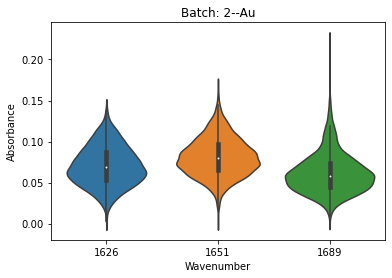

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

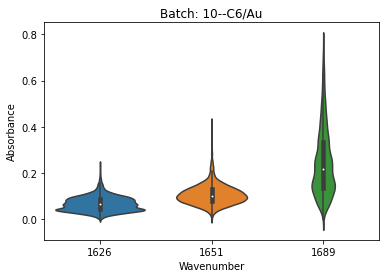

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

H 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 o

H 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 o

H 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 o

'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 

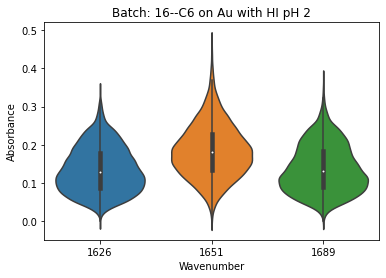

'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 

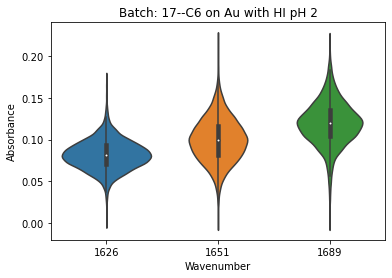

'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 

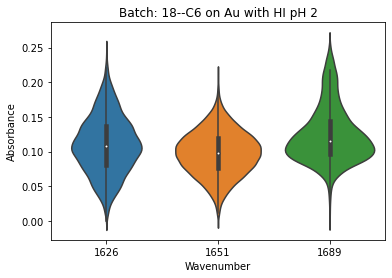

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

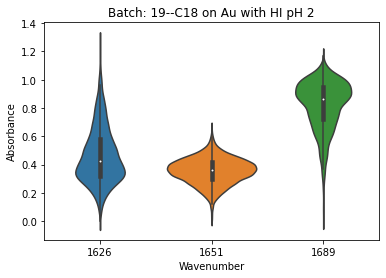

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

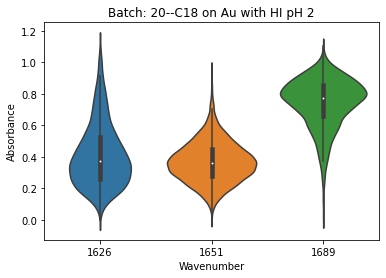

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 

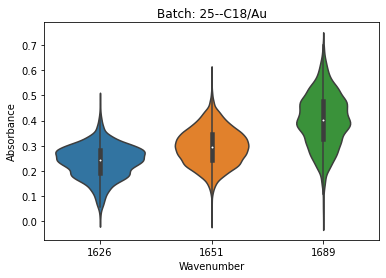

'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 

'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 

H 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 o

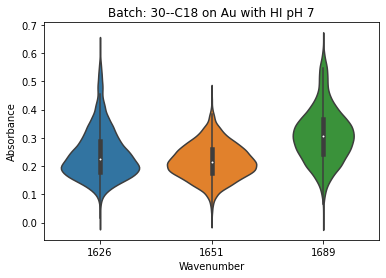

'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 

'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 

, 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'A

, 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'Au', 'A

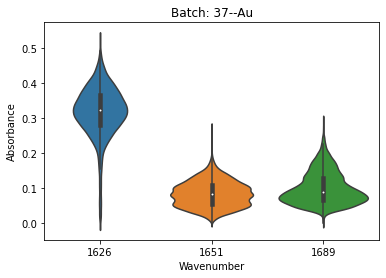

'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 'C18/Au', 

, 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au', 'C6/Au',

'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 'C6 on Au with HI pH 7', 

H 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 on Au with HI pH 7', 'C18 o

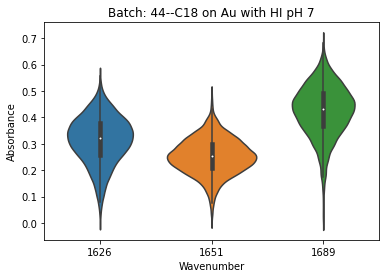

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

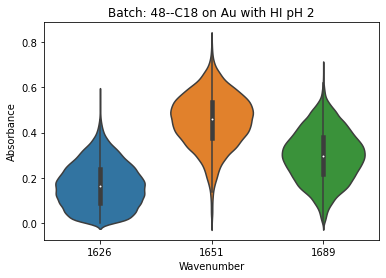

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

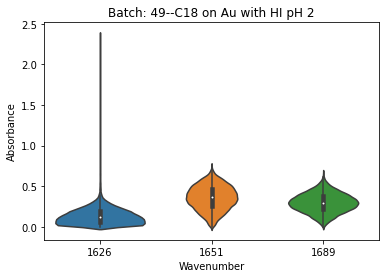

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

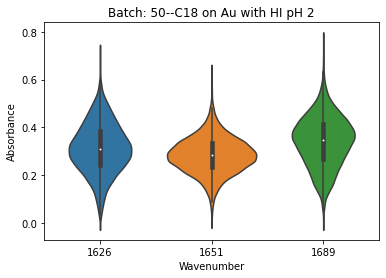

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

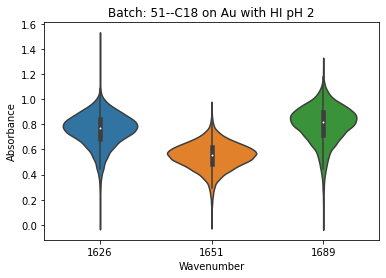

H 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 on Au with HI pH 2', 'C18 o

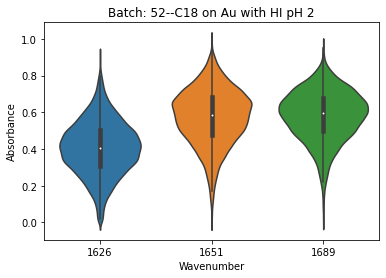

'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 'C6 on Au with HI pH 2', 

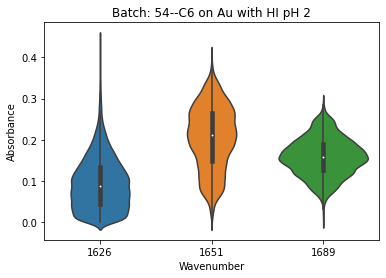

In [33]:
#

#dataset = df.query("background_scan=='none' & Accept in ['y','Y']")
dataset = df.query("Accept in ['y','Y']")

dataset['Wavenumber']=dataset.apply(lambda row: row['wavenumber'].replace(' ','')[:4], axis=1)

dataset['sensitivity'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.sensitivity).groups()[0]), axis=1)
dataset['pulse_width'] = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_width).groups()[0]), axis=1)
dataset['pulse_rate']  = dataset.apply(lambda row: int(re.search("([0-9]+)", row.pulse_rate).groups()[0]) , axis=1)
#dataset['Background'] =  dataset.apply(lambda row: bkgs[row['background_scan']][row['Wavenumber']], axis=1)

dataset['Transmittance']=dataset.apply(lambda row: ((row['FSNOM'].flatten()*row.sensitivity)/(row.pulse_rate*row.pulse_width)), axis=1)

dataset['Transmittance'] = np.abs(dataset.apply(lambda row: row.Transmittance/(row.Transmittance.max()),axis=1))


dataset = dataset.explode('Transmittance')
dataset = dataset.astype({'Transmittance': 'float32'})
dataset['Absorbance'] = -np.log10(dataset['Transmittance'])
#dataset['Absorbance'] = dataset['Absorbance'].replace([np.inf, -np.inf], 0)

all_means = {}

for name, df_ in dataset.groupby('Batch'):

    if df_['index'].nunique() <= 2:
        continue

    df_ = df_.sort_values(by='Wavenumber')

    sample = df_['sample'].values[0]

    gm = scipy.stats.gmean([df['Absorbance'].std() for _, df in df_.groupby('Wavenumber')])

    # Calculate the mean of alpha and subtract from beta sheet1
    batch_means = {}
    for wn, df_wn in df_.groupby('Wavenumber'):
        batch_means[wn] = df_wn['Absorbance'].mean()/gm
    
    batch_means['Batch'] = int(name)
    batch_means['index'] = int(df_wn['index'].unique()[0])
    all_means[name] = batch_means

    print(df_wn['sample'].tolist())

    fig, ax = plt.subplots()
    sns.violinplot(x='Wavenumber',y='Absorbance',data=df_,ax=ax)

    ax.set_title(f'Batch: {name}--{sample}')
    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Stingray_plots/{name}.pdf')
    plt.show()

all_data = pd.DataFrame(all_means).T

In [22]:
all_data['A-B1'] = all_data['1651'] - all_data['1626']
all_data['A-B2'] = all_data['1651'] - all_data['1689']
all_data['A-Ba'] = all_data['1651'] - (all_data['1626']+all_data['1689'])/2
all_data['A-Bs'] = all_data['1651'] - (all_data['1626']+all_data['1689'])

In [23]:
df.query("Accept in ['y','Y'] & sample=='C6 on Au with HI pH 2'").loc[:,['Accept','Batch','index']]

Accept  Batch  index
61       Y     53   2323
62       Y     53   2325
63       Y     54   2326
64       Y     54   2327
65       Y     54   2328
66       Y     54   2329
112      y     16   2705
113      y     16   2706
114      y     16   2707
115      y     17   2708
116      y     17   2709
117      y     17   2710
118      y     18   2711
119      y     18   2712
120      y     18   2713
148      y     29   2750
149      y     29   2751
150      y     29   2752

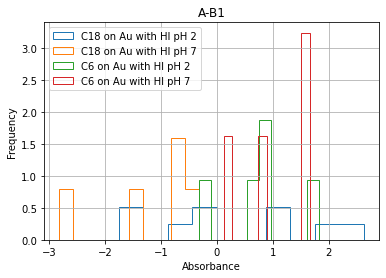

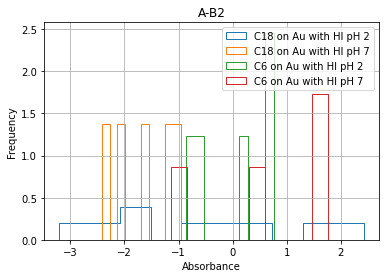

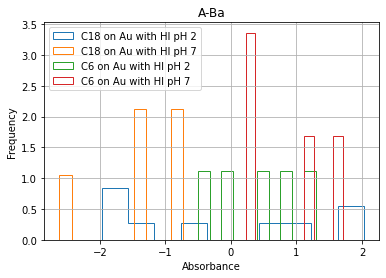

In [24]:
plot_df = all_data.reset_index().merge(df.query("background_scan!='none' & Accept in ['y','Y']"), left_on='index',right_on='index')#.drop_duplicates(subset='Batch')

for title in ['A-B1', 'A-B2', 'A-Ba','A-Bs']:
    
    fig, ax = plt.subplots()
    plot_df.groupby('sample')[title].hist(density=True,legend=True,histtype='step', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Absorbance')
    ax.set_ylabel('Frequency')

    fig.savefig(f'/mnt/c/Users/conor/Git_Projects/PHD/Work_For_Caroline/Absorbance_plots/{title}.pdf')


In [25]:
df.sample(3)

index                                              FSNOM  \
18    2275  [[1008, 979, 983, 943, 900, 932, 1042, 1097, 1...   
107   2699  [[636, 642, 649, 631, 576, 544, 534, 564, 566,...   
126   2719  [[854, 782, 714, 717, 707, 703, 837, 1019, 114...   

                                                 BSNOM  level_0 Accept  Batch  \
18   [[1156, 1031, 935, 988, 1067, 1148, 1166, 1175...       18      y     36   
107  [[514, 506, 532, 577, 617, 671, 718, 716, 742,...      107      y     14   
126  [[722, 860, 1074, 1251, 1570, 1904, 2211, 2454...      126      y     20   

                                              fileName    name  \
18   /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2275-0   
107  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2699-0   
126  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2719-0   

              start_time             end_time  ...  time_constant  \
18   17/07/2019 13:54:28  17/07/2019 14:24:00  ...         500 us   
107  25/08/2020 15:26:33  25/08/2020 15:44:14  ...          10 ms   
126  26/08/2020 17:23:29  26/08/2020 17:23:27  ...          10 ms   

                     sample  background_scan area  operator  Scan Number  \
18                       Au             none  1.0       NaN         2275   
107  C18 on Au with HI pH 7           C18/Au  2.0     Conor         2699   
126  C18 on Au with HI pH 2           C18/Au  2.0     Conor         2719   

     Wavenumber (cm-1)  Skewness  Kurtosis Kurtosis-3  
18           1689 cm-1   -0.0106    3.1039     0.1039  
107          1651 cm-1    0.7295    3.6178     0.6178  
126           1626cm-1    0.2241    2.5256    -0.4744  

[3 rows x 40 columns]

In [27]:
summary = all_data.reset_index().merge(df.query("Accept in ['y','Y']"), left_on='Batch',right_on='Batch').drop(['FSNOM','BSNOM'], axis=1)

In [28]:
df.to_excel('./Insulin_Summary_1412.xlsx')

In [31]:
df.query("sample=='Au'")

index                                              FSNOM  \
18   2275  [[1008, 979, 983, 943, 900, 932, 1042, 1097, 1...   
19   2276  [[803, 758, 733, 710, 687, 641, 609, 564, 551,...   
20   2277  [[1396, 1417, 1398, 1319, 1279, 1318, 1402, 14...   
73   2343  [[1627, 1635, 1619, 1603, 1600, 1616, 1643, 16...   
74   2344  [[1958, 1932, 1902, 1875, 1879, 1893, 1908, 19...   
75   2345  [[2935, 2938, 3099, 3221, 3179, 3048, 2961, 29...   
76   2657  [[2350, 2409, 2468, 2556, 2652, 2776, 2851, 29...   
77   2658  [[1589, 1591, 1565, 1566, 1601, 1620, 1628, 16...   
78   2659  [[1842, 1847, 1826, 1796, 1764, 1769, 1743, 17...   
79   2660  [[2462, 2491, 2461, 2458, 2414, 2389, 2398, 24...   
80   2661  [[1136, 1111, 1116, 1095, 1076, 1080, 1086, 10...   
81   2662  [[1663, 1680, 1718, 1773, 1785, 1749, 1725, 17...   
82   2663  [[1756, 1718, 1702, 1775, 1789, 1779, 1807, 18...   
83   2664  [[1212, 1209, 1165, 1211, 1257, 1245, 1259, 12...   
84   2665  [[1241, 1243, 1245, 1218, 1220, 1231, 1237, 12...   

                                                BSNOM  level_0 Accept  Batch  \
18  [[1156, 1031, 935, 988, 1067, 1148, 1166, 1175...       18      y     36   
19  [[548, 535, 535, 562, 542, 586, 689, 755, 712,...       19      y     36   
20  [[1319, 1452, 1549, 1515, 1461, 1442, 1488, 14...       20      y     36   
73  [[1417, 1421, 1397, 1384, 1385, 1407, 1416, 14...       73      Y     37   
74  [[1900, 1909, 1896, 1874, 1858, 1847, 1846, 18...       74      Y     37   
75  [[4491, 4380, 4266, 4175, 4457, 4633, 4275, 38...       75      Y     37   
76  [[1605, 1660, 1671, 1674, 1707, 1711, 1752, 17...       76      n      1   
77  [[1612, 1620, 1609, 1611, 1603, 1590, 1580, 15...       77      n      1   
78  [[2078, 2064, 2101, 2078, 2079, 2090, 2050, 20...       78      n      1   
79  [[2387, 2356, 2450, 2413, 2448, 2416, 2382, 23...       79      Y      2   
80  [[1123, 1116, 1128, 1191, 1151, 1139, 1158, 11...       80      Y      2   
81  [[1693, 1766, 1843, 1791, 1788, 1826, 1786, 18...       81      Y      2   
82  [[1710, 1729, 1789, 1784, 1759, 1767, 1736, 17...       82      Y      2   
83  [[1283, 1257, 1299, 1335, 1357, 1346, 1371, 13...       83      Y      3   
84  [[1187, 1178, 1176, 1173, 1183, 1169, 1163, 11...       84      Y      3   

                                             fileName    name  \
18  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2275-0   
19  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2276-0   
20  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2277-0   
73  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2343-0   
74  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2344-0   
75  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2345-0   
76  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2657-0   
77  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2658-0   
78  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2659-0   
79  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2660-0   
80  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2661-0   
81  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2662-0   
82  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2663-0   
83  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2664-0   
84  /mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant...  2665-0   

             start_time             end_time  ...  time_constant  sample  \
18  17/07/2019 13:54:28  17/07/2019 14:24:00  ...         500 us      Au   
19  17/07/2019 14:27:05  17/07/2019 14:56:35  ...         500 us      Au   
20  17/07/2019 14:57:41  17/07/2019 15:27:12  ...         500 us      Au   
73  07/08/2019 08:18:37  07/08/2019 08:47:15  ...          50 ms      Au   
74  07/08/2019 08:47:54  07/08/2019 09:16:33  ...          50 ms      Au   
75  07/08/2019 09:17:25  07/08/2019 09:46:05  ...          50 ms      Au   
76  22/08/2020 13:11:10  22/08/2020 13:28:54  ...          10 ms      Au   
77  22/08/2020 14:11:57  22/08/2020 14:29:39  ...

In [36]:
with pd.ExcelWriter('./Insulin_Summary.xlsx') as writer:
    
    for samp_n, samp_df in summary.groupby('sample'):

        sn = samp_n.replace('/','_')

        samp_df.to_excel(writer, sheet_name=f'{sn}')

In [ ]:
def cross_correlate(f,b):

    corr=correlate2d(f, b)

    new_i = np.unravel_index(corr.argmax(), corr.shape)

    fb=np.max([f.shape, b.shape], axis=0)

    output=np.zeros(fb)

    output[0:f.shape[0],0:f.shape[1]] = f
    output[-b.shape[0]:,-b.shape[1]:] = (output[-b.shape[0]:,-b.shape[1]:] + b)/2

    return output


In [ ]:
hist, bins = np.histogram(corr.flatten(), bins=30)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

exp = np.sum(center*(hist/hist.sum()))
exp_i=np.argmin([exp-bin for bin in hist])
print(center[exp_i])

print(np.unravel_index(exp_i, corr.shape))

#plt.plot([bin-exp for bin in hist])
plt.axvline(exp,c='r')

plt.bar(center, hist, align='center', width=width)
plt.show()

In [ ]:
#corr[40:60, 80:100] = 0
#

name = '2720-0-'
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(7,7))

f=SNOM_Import.plane_correct(df.iloc[2].FTOPO)
#f=df.iloc[2].FSNOM
b=SNOM_Import.plane_correct(df.iloc[2].BTOPO)
#b=df.iloc[2].BSNOM

output=cross_correlate(f, b)
corr=correlate2d(f, b)
new_i = np.unravel_index(corr.argmax(), corr.shape)

ax1.imshow(corr)
ax1.axhline(new_i[0],c='r')
ax1.axvline(new_i[1],c='r')

ax2.imshow(output)
ax3.imshow(f)
ax4.imshow(b)

print(f'F({f.shape})')
print(f'B({b.shape})')
print(f'O({output.shape})')

In [ ]:
df.iloc[0]

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4)

for index, row in df.iterrows():

        im_file=row
        print(row.index)



        ftopo = im_file.FTOPO
        fsnom = im_file.FSNOM

        if not isinstance(ftopo, np.ndarray):

                continue

        plane = SNOM_Import.plane_correct(ftopo)

        print(row.background_scan)

        bkg = bkgs[row.background_scan[row.wavelength]]
        correction = row.sensitivity/bkg

        print(correction)

        plane_n = (plane)/plane.max()
        fsnom_n = (fsnom)/fsnom.max()

        print(im_file.fileName)

        data = {'FTOPO': im_file.FTOPO,
                'BTOPO': im_file.BTOPO,
                'FSNOM': im_file.FSNOM,
                'BSNOM': im_file.BSNOM,
                'FTOPO_Tilt_corrected': im_file.FTOPO-SNOM_Import.plane_correct(im_file.FTOPO),
                'BTOPO_Tilt_corrected': im_file.BTOPO-SNOM_Import.plane_correct(im_file.BTOPO),
                'FSNOM_Tilt_corrected': im_file.FSNOM-SNOM_Import.plane_correct(im_file.FSNOM),
                'BSNOM_Tilt_corrected': im_file.BSNOM-SNOM_Import.plane_correct(im_file.BSNOM)}

        if not os.path.exists(os.path.join(os.getcwd(), 'processed_images')):
                os.makedirs(os.path.join(os.getcwd(), 'processed_images'))

        sio.savemat(os.path.join(os.getcwd(), 'processed_images',f'{row.name}.mat'), data)

        for ax, (title, im) in zip(axes.flatten(), data.items()):

                ax.imshow(im)
                ax.set_title(title) 